<a href="https://colab.research.google.com/github/eltongaspar/advpl/blob/Advpl/%23Exercicio%2073%20-%20Reconhecimento%20de%20Texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Atividade de experimentação 73
Detecção de texto em imagens com o detector EAST

In [21]:
#Importando as bibliotecas
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from imutils.object_detection import non_max_suppression
import zipfile

In [22]:
#Conectando com o Drive e acessando os arquivos
# Conectando o Colab ao Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Realize o dowload da pasta Material_complementar_reconhecimento_texto.zip do Google Sala de Aula e transfira-a para o seu Google Drive
# Localize o caminho da pasta no menu Arquivos, no menu lateral esquerdo
#path = "/content/drive/MyDrive/Material_complementar_reconhecimento_texto.zip"
#zip_object = zipfile.ZipFile(file=path, mode="r")
#zip_object.extractall("./")

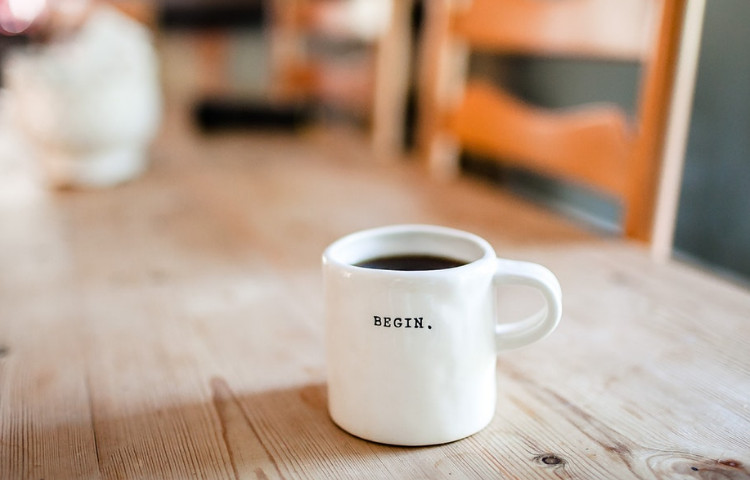

In [24]:
#Processando a imagem
# Definição do detector EAST e dimensões para o processamento da imagem
detector = '/content/drive/MyDrive/Classroom/Inteligência Artificial aplicada à Visão Computacional Turma 99 - 6: 01 02 a 31 05 2024/Material_complementar_reconhecimento_texto/modelos/frozen_east_text_detection.pb'
largura, altura = 320, 320

# Especificação da imagem a ser processada
imagem = '/content/drive/MyDrive/Classroom/Inteligência Artificial aplicada à Visão Computacional Turma 99 - 6: 01 02 a 31 05 2024/Material_complementar_reconhecimento_texto/imagens/caneca.jpg'
min_confianca = 0.9 #@param {type: 'number', min:0.0, max:1.0}

# Leitura e exibição da imagem original
img = cv2.imread(imagem)
cv2_imshow(img)

480 750
2.34375 1.5
320 320


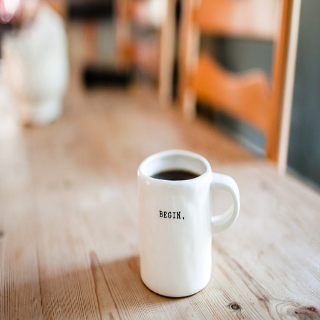

In [25]:
# Cópia da imagem original para uso posterior
original = img.copy()

# Obtém as dimensões da imagem original
H = img.shape[0]
W = img.shape[1]
print(H, W)

# Calcula as proporções da imagem original em relação às dimensões de processamento
proporcao_W = W / float(largura)
proporcao_H = H / float(altura)
print(proporcao_W, proporcao_H)

# Redimensiona a imagem para as dimensões definidas para o processamento
img = cv2.resize(img, (largura, altura))
H = img.shape[0]
W = img.shape[1]
print(H, W)
cv2_imshow(img)



In [26]:
#Carregando a rede neural

# Nomes das camadas de saída da rede EAST
nomes_camadas = ['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3']

# Carrega a rede neural EAST
rede_neural = cv2.dnn.readNet(detector)

# Cria um blob da imagem para ser usado como entrada da rede neural
blob = cv2.dnn.blobFromImage(img, 1.0, (W, H), swapRB = True, crop = False)

# Passa o blob para a rede neural e obtém as pontuações (scores) e a geometria
rede_neural.setInput(blob)
scores, geometry = rede_neural.forward(nomes_camadas)

# Decodifica os valores de geometria para obter as caixas delimitadoras
linhas, colunas = scores.shape[2:4]
caixas = []
confiancas = []

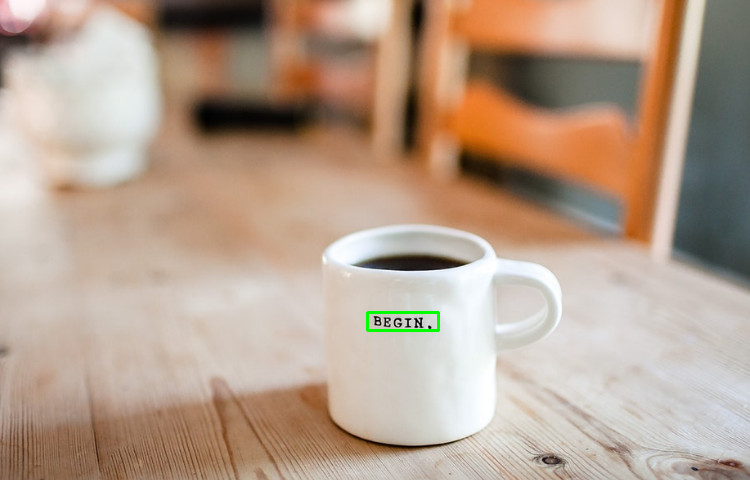

In [27]:
#Decodificando os valores
# Função para obter dados geométricos necessários para calcular as caixas delimitadoras
def dados_geometricos(geometry, y):
  xData0 = geometry[0, 0, y]
  xData1 = geometry[0, 1, y]
  xData2 = geometry[0, 2, y]
  xData3 = geometry[0, 3, y]
  data_angulos = geometry[0, 4, y]
  return data_angulos, xData0, xData1, xData2, xData3

  # Função para calcular as caixas delimitadoras a partir dos dados geométricos
def calculos_geometria(data_angulos, xData0, xData1, xData2, xData3):
  (offsetX, offsetY) = (x * 4.0, y * 4.0)
  angulo = data_angulos[x]
  cos = np.cos(angulo)
  sin = np.sin(angulo)
  h = xData0[x] + xData2[x]
  w = xData1[x] + xData3[x]

  fimX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
  fimY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))

  inicioX = int(fimX - w)
  inicioY = int(fimY - h)

  return inicioX, inicioY, fimX, fimY

  # Iteração sobre as pontuações e geometrias para encontrar caixas delimitadoras
for y in range(0, linhas):
  #print(y)
  data_scores = scores[0, 0, y]

  data_angulos, xData0, xData1, xData2, xData3 = dados_geometricos(geometry, y)

  for x in range(0, colunas):
    if data_scores[x] < min_confianca:
      continue

    inicioX, inicioY, fimX, fimY = calculos_geometria(data_angulos, xData0, xData1, xData2, xData3)
    confiancas.append(data_scores[x])
    caixas.append((inicioX, inicioY, fimX, fimY))

  # Aplica a supressão de máxima não-máxima para filtrar caixas delimitadoras redundantes
deteccoes = non_max_suppression(np.array(caixas), probs=confiancas)

# Redimensiona as caixas delimitadoras para as dimensões da imagem original
copia = original.copy()
for (inicioX, inicioY, fimX, fimY) in deteccoes:
  #print(inicioX, inicioY, fimX, fimY)
  inicioX = int(inicioX * proporcao_W)
  inicioY = int(inicioY * proporcao_H)
  fimX = int(fimX * proporcao_W)
  fimY = int(fimY * proporcao_H)

  # region of interest
  roi = copia[inicioY:fimY, inicioX:fimX]

cv2.rectangle(original, (inicioX, inicioY), (fimX, fimY), (0,255,0), 2)
cv2_imshow(original)

# Exibe a região de interesse (ROI) da última caixa delimitadora
cv2_imshow(roi)
roi = cv2.resize(roi, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)
cv2_imshow(roi)

In [28]:
##Reconhecimento do texto
# Instalação do Tesseract OCR
!sudo apt install tesseract-ocr
!pip install pytesseract
# Importação do Tesseract OCR
import pytesseract

# Criação do diretório tessdata e download do arquivo de dados do idioma português
!mkdir tessdata
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true

# Exibe ajuda sobre os modos de segmentação de página (PSM) do Tesseract OCR
!tesseract --help-psm
# Configuração do Tesseract OCR
config_tesseract = "--tessdata-dir tessdata --psm 7"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
mkdir: cannot create directory ‘tessdata’: File exists
--2024-04-18 13:01:10--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2024-04-18 13:01:10--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tesseract-ocr/tessdata/main/por.traineddata [following]
--2024-04-18 13:01:10--  https://raw.githubusercontent.com/tesseract-oc

BEGIN,



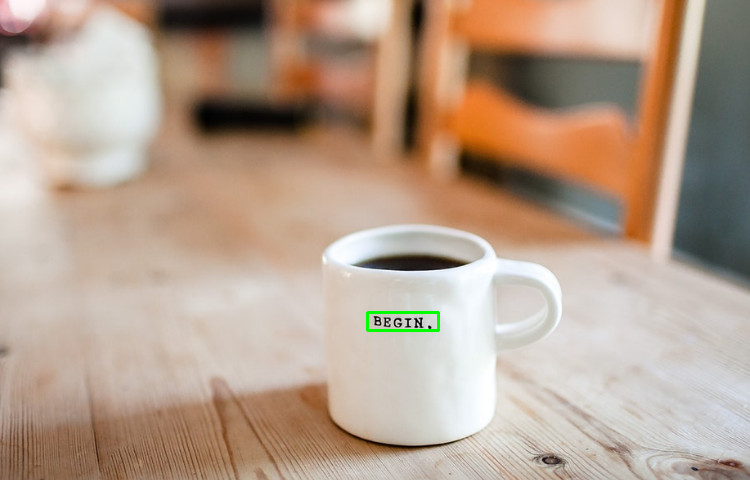

BEGIN,



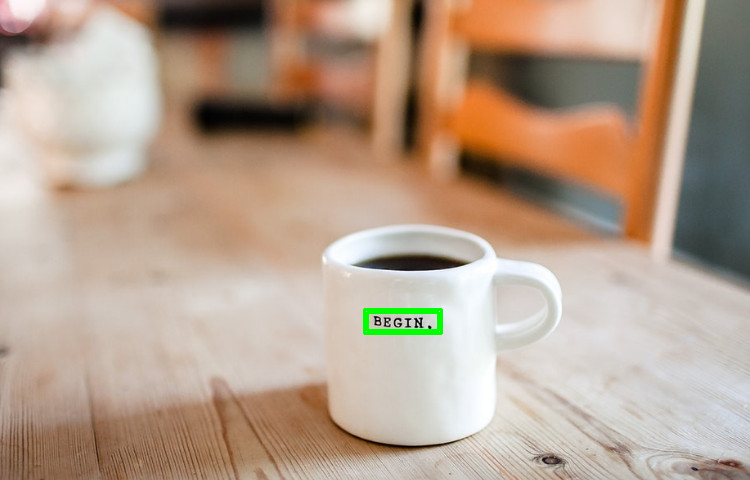

In [29]:
 #Reconhecimento do texto nas ROIs e exibição do texto reconhecido
copia = original.copy()
for (inicioX, inicioY, fimX, fimY) in deteccoes:
  inicioX = int(inicioX * proporcao_W)
  inicioY = int(inicioY * proporcao_H)
  fimX = int(fimX * proporcao_W)
  fimY = int(fimY * proporcao_H)

  roi = copia[inicioY:fimY, inicioX:fimX]
  texto = pytesseract.image_to_string(roi, lang='por', config=config_tesseract)

  # Mostra o texto identificado
  print(texto)

  cv2.rectangle(original, (inicioX, inicioY), (fimX, fimY), (0,255,0), 2)
cv2_imshow(original)

# Expandindo a ROI do texto para melhorar o reconhecimento
margem = 3
copia = original.copy()
for (inicioX, inicioY, fimX, fimY) in deteccoes:
  inicioX = int(inicioX * proporcao_W)
  inicioY = int(inicioY * proporcao_H)
  fimX = int(fimX * proporcao_W)
  fimY = int(fimY * proporcao_H)

  roi = copia[inicioY - margem:fimY + margem, inicioX - margem:fimX + margem]
  cv2_imshow(roi)
  texto = pytesseract.image_to_string(roi, lang='por', config=config_tesseract)

  # Mostra o texto identificado
  print(texto)

  cv2.rectangle(copia, (inicioX - margem, inicioY - margem), (fimX + margem, fimY + margem), (0,255,0), 2)
cv2_imshow(copia)